## Ant metadata template
Extracts metadata like body measurements from a ```.mymridon``` experiment file and saves it as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio. Script also shows how to link a ```tag_id``` (the "baracode") to the unique ```ant_id``` (internally attributed identifier for each ant) for a given period.  
How ant metadata is stored is documented in the [py-myrmidon documentation](https://formicidae-tracker.github.io/myrmidon/latest/api/index.html).

In [1]:
import py_fort_myrmidon as fm
import numpy as np  # Basic math library
import pandas as pd  # Used to create a dataframe, similar to the structure used in R

%load_ext blackcellmagic

We open our example experiment

In [2]:
myrmidonFilePath = "dataset/example.myrmidon"
experiment = fm.Experiment.Open(myrmidonFilePath)

`fort-myrmidon` uses [fm.Time](https://formicidae-tracker.github.io/myrmidon/latest/api/python/time.html#py-fort-myrmidon-time) to represent datetime in UTC. We can select a time range of interest for our analysis from `fort-myrmidon` / `fort-studio` timestamp ( in [RFC 3339](https://datatracker.ietf.org/doc/html/rfc3339) format)

In [3]:
t_start = fm.Time.Parse("2021-02-18T00:00:00.000Z")
t_end = fm.Time.Parse("2021-02-21T00:00:00.000Z")
t_start, t_end

({Time:2021-02-18T00:00:00Z}, {Time:2021-02-21T00:00:00Z})

 Alternatively, we can use [fm.Query.GetDataInformations()](https://formicidae-tracker.github.io/myrmidon/latest/api/python/queries_matchers.html#py_fort_myrmidon.Query.GetDataInformations) to select the whole experiment range

In [4]:
dataInfos = fm.Query.GetDataInformations(experiment)
t_start, t_end = dataInfos.Start, dataInfos.End

We now create a dataframe that will collect for each ant its formatted AntID. We use here a python comprehension, which is a nice python tricks. The expression `[ f(x) for x in list]` must be read as *create a new array with f(x) for every x in list*. It is equivalent (but more efficient) than the follwing snippet of code:
```python
res = []
for x in list:
    res.append(f(x))
```
Here we create one single column 'antID' with the formatted antID as a string, as it is displayed in `fort-studio 

In [5]:
df_metadata = pd.DataFrame(
    data = {
        'antID': [fm.FormatAntID(a.ID) for a in experiment.Ants.values()],
    },
    index = experiment.Ants,
)
df_metadata # pretty print the dataframe to the notebook

,antID
1,001
2,002
3,003
4,004
5,005
...,...
110,110
111,111
112,112
113,113


We will now add to this `pandas.DataFrame` the mean head-tail measurement made in `fort-studio` in pixel. Since its expression is a bit more involved we ue a loop to avoid nested list comprehension, which are hard to read. Alternatively we could have created a function to compute the mean measurement and used a comprehension to be more pythonic and efficient.

In [6]:
print(experiment.MeasurementTypeNames)  # Returns a dictionary with {integer_id: name} of a body measurement 
print(experiment.HEAD_TAIL_MEASUREMENT_TYPE_ID)  # Returns the integer_id of the mandatory head-tail measurement

df_metadata["head_tail_px"] = np.nan
for ant in experiment.Ants:
    head_tail_pixels = fm.Query.ComputeMeasurementFor(experiment=experiment,
                                                      antID=ant,
                                                      measurementTypeID=experiment.HEAD_TAIL_MEASUREMENT_TYPE_ID)
    # this query return an array of measurements, we take the mean of all of them if it exists
    if head_tail_pixels:
        df_metadata.loc[ant, "head_tail_px"] = np.mean([m.LengthPixel for m in head_tail_pixels])
df_metadata

{1: 'head-tail'}
1


,antID,head_tail_px
1,001,273.731152
2,002,282.032754
3,003,291.727613
4,004,301.222409
5,005,298.303255
...,...,...
110,110,282.382467
111,111,284.437742
112,112,269.810206
113,113,285.559101


The following function defines what is called an "iterator function" in python. When defined like here, it can be used to create a loop over days in some datetime range. Unlike the built-in `range(n)` function which return a single element, this function return a tuple that represent the time range subsection

In [7]:
def fm_time_range(
    start: fm.Time,
    end: fm.Time,
    *,
    increment=24 * fm.Duration.Hour,
):
    """Slice a time range is sub-time range 'à la' range()

    Args:
        start (fm.Time): the start time to consider
        end (fm.Time): the end time to consider
        increment (fm.Duration): the time increment to slice the whole time range

    Yields:
        Tuple[fm.Time,fm.Time]: start and end time of the sub range that span at most 'increment'
    """
    while start < end:
        last = start
        start = min(start.Add(increment), end)
        yield last, start

Extract the number of detections in period of 24h ( the default for `fm_time_range()`). Unlike ```fm.Query.staticComputeTagStatistics()```  which reports tag detection, here we only consider our identified Ants. For that purpose, we query for all trajectories , and we count the number of each trajectory points.

In [8]:
df_metadata["counts"] = 0
for t_begin, t_last in fm_time_range(t_start, t_end):
    print(f"sub-period [{t_begin}; {t_last}[")
    trajectories = fm.Query.ComputeAntTrajectories(
        experiment=experiment,
        start=t_begin,
        end=t_last,
    )
    for t in trajectories:
        df_metadata.loc[t.Ant, "counts"] += len(t.Positions)

sub-period [2021-02-15T21:29:41.057846219Z; 2021-02-16T21:29:41.057846219Z[


Computing ant trajectories: 100%|▉| 1439/1440 [00:13<00:00, 107.95tracked min/s]


sub-period [2021-02-16T21:29:41.057846219Z; 2021-02-17T21:29:41.057846219Z[


Computing ant trajectories: 100%|▉| 1439/1440 [00:13<00:00, 102.91tracked min/s]


sub-period [2021-02-17T21:29:41.057846219Z; 2021-02-18T21:29:41.057846219Z[


Computing ant trajectories: 100%|█▉| 1439/1440 [00:14<00:00, 97.02tracked min/s]


sub-period [2021-02-18T21:29:41.057846219Z; 2021-02-19T21:29:41.057846219Z[


Computing ant trajectories: 100%|█▉| 1439/1440 [00:15<00:00, 91.91tracked min/s]


sub-period [2021-02-19T21:29:41.057846219Z; 2021-02-19T23:29:39.542389711Z[


Computing ant trajectories:  99%|███▉| 120/121 [00:01<00:00, 70.53tracked min/s]


Save dataframe and optionally plot.

In [9]:
f_name = "ant_metadata_{}_{}_{}.csv".format(experiment.Name, t_start, t_end)
df_metadata.to_csv(f_name, index_label='ant_id')
df_metadata  # Show csv preview

,antID,head_tail_px,counts
1,001,273.731152,148581
2,002,282.032754,951051
3,003,291.727613,135147
4,004,301.222409,192689
5,005,298.303255,2250456
...,...,...,...
110,110,282.382467,1400744
111,111,284.437742,474722
112,112,269.810206,1117956
113,113,285.559101,1477313


<AxesSubplot:xlabel='antID'>

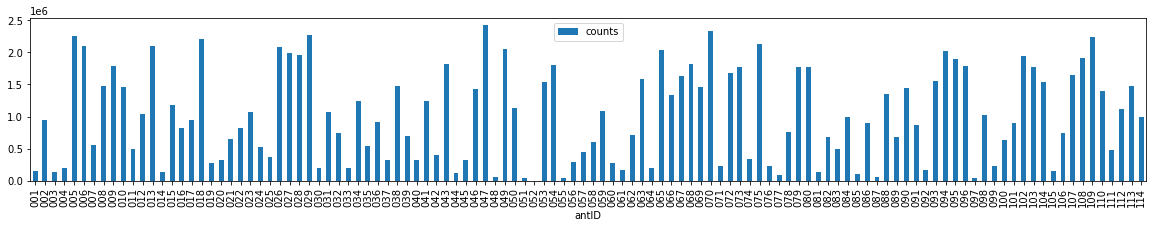

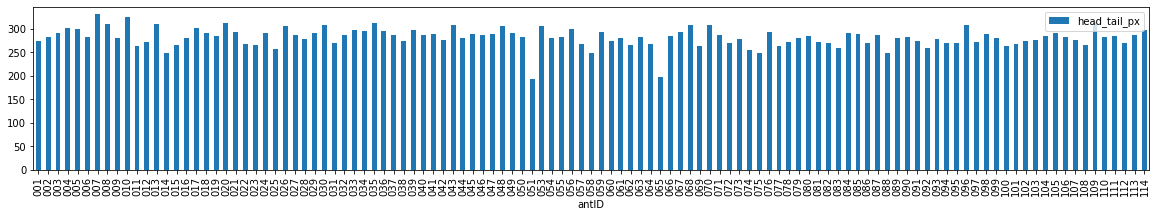

In [10]:
df_metadata.pivot_table(values='counts', index='antID').plot(kind='bar', figsize=(20,3))
df_metadata.pivot_table(values='head_tail_px', index='antID').plot(kind='bar', figsize=(20,3))